In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

  Using cached duckdb_engine-0.13.1-py3-none-any.whl (47 kB)
  Using cached packaging-24.1-py3-none-any.whl (53 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [2]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [3]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-07-02'

In [4]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [5]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;
%sql SELECT * FROM raw_db.billboard.artist LIMIT 2;

,artist_id,artist_name,pct_female,last_update
0,1,Zach Bryan,0.0,2024-08-23
1,2,Morgan Wallen,0.0,2024-08-23


# Update upload/rank_by_name

In [6]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [7]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
# from upload.rank_by_name import rankings
from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['I Had Some Help',
 'A Bar Song (Tipsy)',
 'Pour Me A Drink',
 'Pink Skies',
 'Cowgirls',
 '...',
 'Purple Gas',
 "Huntin' By Yourself",
 'Front Door Famous',
 'Wanna Be Loved',
 "Drink Don't Need No Mix"]

In [8]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [9]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
| 20 |        38 | I Had Some Help | Morgan Wallen | Other main artist   |                          0 |
| 99 |        38 | I Had Some Help | Post Malone   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 16 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---

Please enter the song_id or 'New Song'

|    |   song_id | song_name        | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-----------------|:--------------|:--------------------|---------------------------:|
| 21 |        39 | Beautiful As You | Thomas Rhett  | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name                | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------------|:--------------|:--------------------|---------------------------:|
| 85 |       108 | Let Your Boys Be Country | Jason Aldean  | Lead artist         |                          1 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name        | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-----------------|:--------------|:--------------------|---------------------------:|
| 24 |        42

Please enter the song_id or 'New Song'



In [10]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(json.dumps(new_song_to_rank, indent = 2))

43 +
{
  "Halfway To Hell": 24,
  "Texas Hold 'Em": 26,
  "We Don't Fight Anymore": 27,
  "Take Her Home": 39,
  "My Fault": 45,
  "Huntin' By Yourself": 47,
  "Front Door Famous": 48
}


## Add artists on any new songs that aren't in the artist table yet to its CSV

  "Halfway To Hell": Jelly Roll +2,
  "Texas Hold 'Em": Beyonce,
  "We Don't Fight Anymore": Carly Pearce feat. Chris Stapleton +22,
  "Take Her Home": Kenny Chesney +1,
  "My Fault": Shaboozey feat. Noah Cyrus,
  "Huntin' By Yourself": Luke Combs,
  "Front Door Famous": Luke Combs

In [12]:
df_artist = pd.read_csv('source_data/artist.csv')

In [13]:
new_song_artists = [
    'Jelly Roll' # 5
    , 'Luke Combs' # 6
    , 'Beyonce' # 3
    , 'Carly Pearce' # 23
    , 'Chris Stapleton' # 12
    , 'Kenny Chesney' # new
    , 'Shaboozey' # 25
    , 'Noah Cyrus' # new
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
2,3,Beyonce,1.0,2024-08-23
4,5,Jelly Roll,0.0,2024-08-23
5,6,Luke Combs,0.0,2024-08-23
11,12,Chris Stapleton,0.0,2024-08-23
22,23,Carly Pearce,1.0,2024-08-23
24,25,Shaboozey,0.0,2024-08-23


In [14]:
df_artist['artist_id'].max()

68

In [15]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [69, 'Kenny Chesney', 0, current_date]
                , [70, 'Noah Cyrus', 1, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [16]:
df_artist.to_csv('source_data/artist.csv', index=False)

## Add all new songs to the song table CSV

In [17]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [21]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[115, 'Halfway To Hell', 0, '2024-09-13'],
 [116, "Texas Hold 'Em", 0, '2024-09-13'],
 [117, "We Don't Fight Anymore", 0, '2024-09-13'],
 [118, 'Take Her Home', 0, '2024-09-13'],
 [119, 'My Fault', 0, '2024-09-13'],
 [120, "Huntin' By Yourself", 0, '2024-09-13'],
 [121, 'Front Door Famous', 0, '2024-09-13']]

In [22]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)

In [25]:
# Update untracked_weeks_on_chart if needed
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
113,114,Song While You're Away,0.0,2024-09-13
114,115,Halfway To Hell,2,2024-09-13
115,116,Texas Hold 'Em,0,2024-09-13
116,117,We Don't Fight Anymore,22,2024-09-13
117,118,Take Her Home,1,2024-09-13
118,119,My Fault,0,2024-09-13
119,120,Huntin' By Yourself,0,2024-09-13
120,121,Front Door Famous,0,2024-09-13


In [24]:
# Adjust untracked weeks if they aren't zero
df_song_raw.loc[114, 'untracked_weeks_on_chart'] = 2
df_song_raw.loc[116, 'untracked_weeks_on_chart'] = 22
df_song_raw.loc[117, 'untracked_weeks_on_chart'] = 1

In [26]:
df_song_raw.to_csv('source_data/song.csv', index=False)

#### Add all new songs to the song_to_artist table CSV

#### Paste new songs list here
  "Halfway To Hell": Jelly Roll +2,
  "Texas Hold 'Em": Beyonce,
  "We Don't Fight Anymore": Carly Pearce feat. Chris Stapleton +22,
  "Take Her Home": Kenny Chesney +1,
  "My Fault": Shaboozey feat. Noah Cyrus,
  "Huntin' By Yourself": Luke Combs,
  "Front Door Famous": Luke Combs

In [27]:
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
2,3,Beyonce,1.0,2024-08-23
4,5,Jelly Roll,0.0,2024-08-23
5,6,Luke Combs,0.0,2024-08-23
11,12,Chris Stapleton,0.0,2024-08-23
22,23,Carly Pearce,1.0,2024-08-23
24,25,Shaboozey,0.0,2024-08-23
68,69,Kenny Chesney,0,2024-09-13
69,70,Noah Cyrus,1,2024-09-13


In [28]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

In [29]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [115, 5, '', '']
    , [116, 3, '', '']
    , [117, 23, '', '']
    , [117, 12, '', 1]
    , [118, 69, '', '']
    , [119, 25, '', '']
    , [119, 70, '', 1]
    , [120, 6, '', '']
    , [121, 6, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['115-Lead artist-', 115, 5, 'Lead artist', '', '', '2024-09-13'],
 ['116-Lead artist-', 116, 3, 'Lead artist', '', '', '2024-09-13'],
 ['117-Lead artist-', 117, 23, 'Lead artist', '', '', '2024-09-13'],
 ['117-Featured artist-1', 117, 12, 'Featured artist', '', 1, '2024-09-13'],
 ['118-Lead artist-', 118, 69, 'Lead artist', '', '', '2024-09-13'],
 ['119-Lead artist-', 119, 25, 'Lead artist', '', '', '2024-09-13'],
 ['119-Featured artist-1', 119, 70, 'Featured artist', '', 1, '2024-09-13'],
 ['120-Lead artist-', 120, 6, 'Lead artist', '', '', '2024-09-13'],
 ['121-Lead artist-', 121, 6, 'Lead artist', '', '', '2024-09-13']]

In [30]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)

In [31]:
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
140,121-Lead artist-,121,6,Lead artist,,,2024-09-13


In [32]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)

#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [33]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

In [34]:
array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come last

[['2024-07-02-27', '2024-07-02', 27, 117, '2024-09-13'],
 ['2024-07-02-39', '2024-07-02', 39, 118, '2024-09-13'],
 ['2024-07-02-45', '2024-07-02', 45, 119, '2024-09-13'],
 ['2024-07-02-47', '2024-07-02', 47, 120, '2024-09-13'],
 ['2024-07-02-48', '2024-07-02', 48, 121, '2024-09-13']]

In [35]:
df_billboard_ranking_raw = pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)

In [36]:
df_billboard_ranking_raw.to_csv('source_data/billboard_ranking.csv', index=False)

## Push to duckdb

In [37]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

## Run the ranking SQL script

In [48]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT *
        FROM billboard.billboard_ranking
        WHERE song_id = 119
        """
    ))

┌──────────────────────┬────────────────────────────┬────────────────┬─────────┬─────────────┐
│ billboard_ranking_pk │ billboard_observation_date │ billboard_rank │ song_id │ last_update │
│       varchar        │            date            │     int32      │  int32  │    date     │
├──────────────────────┼────────────────────────────┼────────────────┼─────────┼─────────────┤
│ 2024-07-02-45        │ 2024-07-02                 │             45 │     119 │ 2024-09-13  │
└──────────────────────┴────────────────────────────┴────────────────┴─────────┴─────────────┘



In [69]:
with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/artist_ranking.sql') as sql_file:
        artist_ranking = conn.sql(sql_file.read())
    
    df_artist_ranking = pd.DataFrame(
        data=artist_ranking.fetchall()
        , columns=artist_ranking.columns
    )

In [89]:
pd.set_option('display.max_rows', 100)
cols = list(df_artist_ranking.columns)
n_cols = len(cols)
col_nums = { col:ix for (col,ix) in zip(cols, range(n_cols)) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact.loc[ :, 1 : n_cols - 2 ]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Zach Bryan,90,90,90,114,114,114,21,21,21,21,21,21,4.0,4.0,2024-07-02
1,Post Malone,61,61,61,61,61,61,18,18,18,18,18,18,1.0,1.0,2024-07-02
2,Morgan Wallen,20,31,42,32,43,54,2,3,4,2,3,4,1.0,1.0,2024-07-02
3,Luke Combs,23,23,31,58,58,66,5,5,7,6,6,8,3.0,3.0,2024-07-02
4,Koe Wetzel,22,22,22,22,22,22,2,2,2,2,2,2,9.0,9.0,2024-07-02
5,Jelly Roll,16,22,36,18,24,39,4,5,7,4,5,7,9.0,9.0,2024-07-02
6,Megan Moroney,19,19,19,39,39,39,4,4,4,4,4,4,21.0,21.0,2024-07-02
7,Lainey Wilson,16,16,19,16,51,54,2,2,3,2,3,4,19.0,19.0,2024-07-02
8,Bailey Zimmerman,16,16,16,16,16,16,2,2,2,2,2,2,27.0,27.0,2024-07-02
9,Shaboozey,15,15,15,15,15,15,3,3,3,3,3,3,1.0,1.0,2024-07-02


In [90]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│ 2024-07-10                 │    50 │
│ 2024-07-02                 │    50 │
├────────────────────────────┴───────┤
│ 11 rows                  2 columns │
└────────────────────────────────────┘



In [92]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = '2024-07-10' # or current_date
comparison_observation_date = '2024-07-02'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬─────────────────────────┬────────────────┐
│ song_id │        song_name        │ ranking_before │
│  int32  │         varchar         │     int32      │
├─────────┼─────────────────────────┼────────────────┤
│     115 │ Halfway To Hell         │             24 │
│     116 │ Texas Hold 'Em          │             26 │
│     117 │ We Don't Fight Anymore  │             27 │
│     118 │ Take Her Home           │             39 │
│     119 │ My Fault                │             45 │
│     120 │ Huntin' By Yourself     │             47 │
│     121 │ Front Door Famous       │             48 │
│      54 │ Drink Don't Need No Mix │             50 │
└─────────┴─────────────────────────┴────────────────┘



# Scratch work to get song sparklines

In [ ]:
# TODO add a measurement start date column for Friday of each week based on observation date

In [95]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [96]:
%%sql df_a_song <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
WHERE br.song_id IN (63, 64) -- # Out Of Oklahoma, Guy For That
ORDER BY 1 ASC
;

In [97]:
df_a_song

,billboard_observation_date,song_id,song_name,billboard_rank
0,2024-07-31,63,Out Of Oklahoma,45
1,2024-08-07,64,Guy For That,7
2,2024-08-07,63,Out Of Oklahoma,43
3,2024-08-13,64,Guy For That,12
4,2024-08-13,63,Out Of Oklahoma,41
5,2024-08-23,64,Guy For That,12
6,2024-08-23,63,Out Of Oklahoma,40
7,2024-08-27,64,Guy For That,7
8,2024-09-05,64,Guy For That,11
9,2024-09-10,64,Guy For That,12


In [98]:
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet

In [105]:
df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf)

song_name,Guy For That,Out Of Oklahoma
billboard_observation_date,,
2024-07-31,inf,45.0
2024-08-07,7.0,43.0
2024-08-13,12.0,41.0
2024-08-23,12.0,40.0
2024-08-27,7.0,inf
2024-09-05,11.0,inf
2024-09-10,12.0,50.0


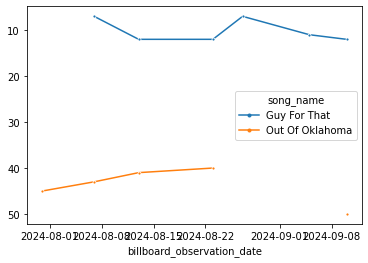

In [123]:
n_lines = 2 # TODO use df.count()

# TODO scale up size
# TODO a line for every song by an artist
# TODO loop through artists
# TODO dash type based on s2a relationship type
graph = sns.lineplot(
    data = df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf) # hide hidden data // TODO: show points with null immediately before and after
    , markers=['.'] * n_lines
    , dashes=False
    # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
)
graph.axes.invert_yaxis()